In [4]:
!pip install imbalanced-learn


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (Windows)
mpl.rc('font', family='Malgun Gothic')

# ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ
mpl.rcParams['axes.unicode_minus'] = False

In [1]:
import pandas as pd
import numpy as np
import mariadb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score
from imblearn.over_sampling import SMOTE  # Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†Ìòï Ìï¥Í≤∞

# üìå 1. MariaDB Ïó∞Í≤∞ ÏÑ§Ï†ï
DB_CONFIG = {
    "user": "root",
    "password": "1234",
    "host": "localhost",
    "database": "finfit"
}

def load_data_from_db():
    """MariaDBÏóêÏÑú Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò§Îäî Ìï®Ïàò"""
    conn = mariadb.connect(**DB_CONFIG)
    query = "SELECT * FROM medical"
    df = pd.read_sql(query, conn)
    conn.close()
    return df.dropna()

# üìå 2. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
health_data = load_data_from_db()
print(f"‚úÖ DBÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å! Ï¥ù {len(health_data)}Í∞úÏùò Îç∞Ïù¥ÌÑ∞\n")

# üìå 3. ÏÇ¨Ïö©Ìï† Ïª¨Îüº Ï†ïÏùò (Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞Îäî XÏóêÏÑú Ï†úÍ±∞!)
columns_to_use = [
    'sex', 'age', 'height', 'weight', 'bmi', 'alchol', 'smoking_history',
    'chol_total', 'chol_hdl', 'chol_ldl', 'chol_tg',
    'fasting_blood_sugar', 'glycated_hemoglobin',
    'sbp_average', 'dbp_average', 'cancer_diagnosis_fathers',
    'cancer_diagnosis_mother', 'cancer_diagnosis_sibling',
    'white_blood_cell_count', 'red_blood_cell_count', 'stress'
]

# üìå 4. Ïïî ÏúÑÌóòÎèÑ Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_cancer_risk(row):
    return (
        (row['cancer_diagnosis_fathers'] * 3) +  
        (row['cancer_diagnosis_mother'] * 3) +  
        (row['cancer_diagnosis_sibling'] * 3) +  
        (row['chol_total'] / 30) +  
        (row['sbp_average'] / 15) +  
        (row['dbp_average'] / 15) +  
        (row['fasting_blood_sugar'] / 15) +  
        (row['glycated_hemoglobin'] * 2.5) +  
        (row['white_blood_cell_count'] * 1.5) +  
        (row['red_blood_cell_count'] * 1.2) +  
        (row['age'] / 20) +  
        (row['bmi'] / 5) +  
        (row['alchol'] * 2) +  
        (row['smoking_history'] * 5) +  
        ((5 - row['stress']) if row['stress'] in [1, 2, 3, 4] else 0) * 2
    )

# Ïïî ÏúÑÌóòÎèÑ Ï†êÏàò Ï∂îÍ∞Ä
health_data['cancer_risk_score'] = health_data.apply(calculate_cancer_risk, axis=1)

# üìå 5. Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞(ÌÉÄÍ≤ü Î≥ÄÏàò) Ï†ïÏùò
disease_labels = {
    'Í≥†ÏßÄÌòàÏ¶ù': 'dyslipidemia_status',
    'ÎãπÎá®': 'diabetes',
    'Í≥†ÌòàÏïï': 'high_blood_pressure'
}

# üìå 6. ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(X)ÏôÄ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞(y) Î∂ÑÎ¶¨
X = health_data[columns_to_use]  # ‚úÖ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ Ï†úÏô∏
y_disease = health_data[list(disease_labels.values())]  # ‚úÖ ÏßàÎ≥ë ÏòàÏ∏°Ïö© Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞
y_cancer = health_data["cancer_risk_score"]  # ‚úÖ Ïïî ÏúÑÌóòÎèÑ ÏòàÏ∏°Ïö© Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞

# üìå 7. Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨ (ÎπÑÏñ¥ ÏûàÎäî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÏñ¥ÎèÑ ÌïôÏäµ Í∞ÄÎä•ÌïòÎèÑÎ°ù)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")  # ÌèâÍ∑†Í∞íÏúºÎ°ú Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
X_imputed = imputer.fit_transform(X)

# üìå 8. Ï†ïÍ∑úÌôî (StandardScaler ÏÇ¨Ïö©)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# üìå 9. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (Train/Test) ‚Üí `X_test`Î•º Í≥µÌÜµÏúºÎ°ú ÏÇ¨Ïö©
X_train, X_test, y_train_disease, y_test_disease, y_train_cancer, y_test_cancer = train_test_split(
    X_scaled, y_disease, y_cancer, test_size=0.2, random_state=42
)

# üìå 10. SMOTE Ï†ÅÏö© (Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†Ìòï Ìï¥Í≤∞) ‚Üí ÏßàÎ≥ë ÏòàÏ∏°ÏóêÎßå Ï†ÅÏö©
# üìå 10. SMOTE Ï†ÅÏö© (Í∞Å ÏßàÎ≥ëÎ≥ÑÎ°ú Í∞úÎ≥Ñ Ï†ÅÏö©)
smote = SMOTE(random_state=42)

X_train_smote_dict = {}  # SMOTE Ï†ÅÏö©Îêú X_train Ï†ÄÏû•
y_train_smote_dict = {}  # SMOTE Ï†ÅÏö©Îêú y_train Ï†ÄÏû•

for disease, label in disease_labels.items():
    X_train_smote_dict[disease], y_train_smote_dict[disease] = smote.fit_resample(X_train, y_train_disease[label])


# üìå 11. ÏßàÎ≥ë ÏòàÏ∏° Î™®Îç∏ ÌïôÏäµ (SMOTE Ï†ÅÏö©Îêú Îç∞Ïù¥ÌÑ∞ÏÖã ÏÇ¨Ïö©)
optimized_models = {}
best_params = {}
predicted_probs = {}

param_grid = {
    'n_estimators': [200],
    'max_depth': [15],
    'min_samples_split': [5],
    'max_features': ['sqrt']
}

for disease, label in disease_labels.items():
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_smote_dict[disease], y_train_smote_dict[disease])  # ‚úÖ SMOTE Ï†ÅÏö©Îêú Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©
    best_params[disease] = grid_search.best_params_

    model = RandomForestClassifier(**best_params[disease], random_state=42)
    model.fit(X_train_smote_dict[disease], y_train_smote_dict[disease])  # ‚úÖ SMOTE Ï†ÅÏö©Îêú Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©
    predicted_probs[disease] = model.predict_proba(X_test)[:, 1]
    optimized_models[disease] = model


# üìå 12. Ïïî ÏúÑÌóòÎèÑ ÏòàÏ∏° Î™®Îç∏ ÌïôÏäµ (RandomForestRegressor ÏÇ¨Ïö©)
cancer_model = RandomForestRegressor(n_estimators=200, random_state=42)
cancer_model.fit(X_train, y_train_cancer)
predicted_probs["Ïïî"] = cancer_model.predict(X_test)

# üìå 13. Ïïî ÏúÑÌóòÎèÑ Ï†êÏàò Î∞±Î∂ÑÏúÑ Î≥ÄÌôò
health_data["cancer_risk_percentile"] = health_data["cancer_risk_score"].rank(pct=True, ascending=True) * 100
cancer_risk_percentile = health_data.loc[y_test_cancer.index, "cancer_risk_percentile"].values

# üìå 14. ÏúÑÌóòÎèÑ Î∂ÑÎ•ò Ìï®Ïàò Ï∂îÍ∞Ä
def classify_general_risk(prob):
    """ÏùºÎ∞òÏ†ÅÏù∏ Ïú†Î≥ë ÌôïÎ•†ÏùÑ Ï†ÄÏúÑÌóò/Ï§ëÏúÑÌóò/Í≥†ÏúÑÌóòÏúºÎ°ú Î≥ÄÌôò"""
    if prob < 0.10:
        return "Ï†ÄÏúÑÌóò"
    elif prob < 0.30:
        return "Ï§ëÏúÑÌóò"
    else:
        return "Í≥†ÏúÑÌóò"

def classify_cancer_risk(percentile):
    """Ïïî ÏúÑÌóòÎèÑ ÏàúÏúÑÎ•º Î∞îÌÉïÏúºÎ°ú ÏúÑÌóòÎèÑ Î∂ÑÎ•ò"""
    if percentile <= 10:
        return "Í≥†ÏúÑÌóò"
    elif percentile <= 30:
        return "Ï§ëÏúÑÌóò"
    else:
        return "Ï†ÄÏúÑÌóò"

# üìå 15. ÏµúÏ¢Ö Í≤∞Í≥º Ï†ïÎ¶¨ (ÏúÑÌóòÎèÑ Ï∂îÍ∞Ä!)
risk_data = pd.DataFrame({
    "Í≥†ÏßÄÌòàÏ¶ù Ïú†Î≥ë ÌôïÎ•†": predicted_probs["Í≥†ÏßÄÌòàÏ¶ù"],
    "ÎãπÎá® Ïú†Î≥ë ÌôïÎ•†": predicted_probs["ÎãπÎá®"],
    "Í≥†ÌòàÏïï Ïú†Î≥ë ÌôïÎ•†": predicted_probs["Í≥†ÌòàÏïï"],
    "Ïïî ÏúÑÌóòÎèÑ Ï†êÏàò": predicted_probs["Ïïî"],
    "Ïïî ÏúÑÌóòÎèÑ": [classify_cancer_risk(x) for x in cancer_risk_percentile],
    "Ïïî ÏúÑÌóòÎèÑ ÏàúÏúÑ": [f"ÏÉÅÏúÑ {int(x)}%" for x in cancer_risk_percentile],  # ‚úÖ Î∞±Î∂ÑÏúÑ Î≥ÄÌôò
})

# üìå **ÏúÑÌóòÎèÑ(Ï†ÄÏúÑÌóò/Ï§ëÏúÑÌóò/Í≥†ÏúÑÌóò) Ï†ïÎ≥¥ Ï∂îÍ∞Ä**
for disease in ["Í≥†ÏßÄÌòàÏ¶ù", "ÎãπÎá®", "Í≥†ÌòàÏïï"]:
    risk_data[f"{disease} ÏúÑÌóòÎèÑ"] = risk_data[f"{disease} Ïú†Î≥ë ÌôïÎ•†"].apply(classify_general_risk)  # ‚úÖ ÏúÑÌóòÎèÑ Ï∂îÍ∞Ä!

# üìå ÌôïÎ•† Í∞íÏùÑ %Î°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò
def format_percentage(value):
    return f"{value * 100:.1f}%"  # Ïòà: 0.231 ‚Üí 23.1%

# üìå Í≥†ÏßÄÌòàÏ¶ù, ÎãπÎá®, Í≥†ÌòàÏïï Ïú†Î≥ë ÌôïÎ•†ÏùÑ %Î°ú Î≥ÄÌôò
for disease in ["Í≥†ÏßÄÌòàÏ¶ù", "ÎãπÎá®", "Í≥†ÌòàÏïï"]:
    risk_data[f"{disease} Ïú†Î≥ë ÌôïÎ•†"] = risk_data[f"{disease} Ïú†Î≥ë ÌôïÎ•†"].apply(format_percentage)

# ‚úÖ ÏµúÏ¢Ö Í≤∞Í≥º Ï∂úÎ†•
print("\nüìä Ïú†Î≥ë ÌôïÎ•† Î∞è ÏúÑÌóòÎèÑ Î∂ÑÏÑù Í≤∞Í≥º")
display(risk_data.head(30))


C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\4294391921.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


‚úÖ DBÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å! Ï¥ù 4599Í∞úÏùò Îç∞Ïù¥ÌÑ∞



c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] ÏßÄÏ†ïÎêú ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.


üìä Ïú†Î≥ë ÌôïÎ•† Î∞è ÏúÑÌóòÎèÑ Î∂ÑÏÑù Í≤∞Í≥º


Í≥†ÏßÄÌòàÏ¶ù Ïú†Î≥ë ÌôïÎ•† ÎãπÎá® Ïú†Î≥ë ÌôïÎ•† Í≥†ÌòàÏïï Ïú†Î≥ë ÌôïÎ•†    Ïïî ÏúÑÌóòÎèÑ Ï†êÏàò Ïïî ÏúÑÌóòÎèÑ Ïïî ÏúÑÌóòÎèÑ ÏàúÏúÑ Í≥†ÏßÄÌòàÏ¶ù ÏúÑÌóòÎèÑ ÎãπÎá® ÏúÑÌóòÎèÑ  \
0        3.3%     1.1%      0.0%   79.391456   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 10%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
1        0.8%     0.0%      0.0%   82.728019   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 41%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
2      100.0%     0.0%      2.2%   84.205006   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 45%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
3        1.0%     0.6%      0.1%   80.784810   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 27%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
4        1.6%     0.2%     37.4%   80.115728   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 21%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
5        1.7%     0.1%      0.4%   81.777442   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 28%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
6        4.5%     0.8%      0.0%   78.222898   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 32%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
7        2.2%     0.0%      0.9%   82.219246   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 42%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
8        1.1%     6.0%      1.2%   84.950124   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 53%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
9       93.3%     1.2%      3.6%   88.839683   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 76%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
10       3.1%    56.5%     54.2%   87.106299   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 76%      Ï†ÄÏúÑÌóò    Í≥†ÏúÑÌóò   
11       8.4%     2.0%      1.0%   78.820315   Í≥†ÏúÑÌóò    ÏÉÅÏúÑ 5%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
12       1.3%    94.3%      1.8%   84.191330   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 31%      Ï†ÄÏúÑÌóò    Í≥†ÏúÑÌóò   
13       3.9%     0.2%      0.4%   78.814037   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 17%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
14      99.0%     3.7%     86.1%   91.017191   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 83%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
15       4.9%    73.6%     99.7%   91.671335   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 86%      Ï†ÄÏúÑÌóò    Í≥†ÏúÑÌóò   
16       0.5%     1.2%      0.2%   79.389208   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 10%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
17      98.0%    97.4%      0.7%   88.142372   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 71%      Í≥†ÏúÑÌóò    Í≥†ÏúÑÌóò   
18       0.9%     0.0%      0.0%   76.070269   Í≥†ÏúÑÌóò    ÏÉÅÏúÑ 3%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
19      93.7%     0.2%     14.6%   79.607054   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 28%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
20      92.3%     1.5%      1.5%   80.288770   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 10%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
21      89.7%     0.5%      0.4%   84.152916   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 65%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
22       0.8%     0.0%      0.6%   80.211925   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 21%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
23      95.2%     0.5%      0.4%   87.025175   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 80%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
24      94.8%    52.2%      0.8%   82.968238   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 40%      Í≥†ÏúÑÌóò    Í≥†ÏúÑÌóò   
25      22.3%    99.1%      0.5%   95.713716   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 91%      Ï§ëÏúÑÌóò    Í≥†ÏúÑÌóò   
26      94.8%     0.5%     80.7%   86.984817   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 70%      Í≥†ÏúÑÌóò    Ï†ÄÏúÑÌóò   
27      99.5%    90.1%      8.1%   90.670785   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 84%      Í≥†ÏúÑÌóò    Í≥†ÏúÑÌóò   
28       3.6%     0.9%      0.4%   76.308847   Ï§ëÏúÑÌóò   ÏÉÅÏúÑ 10%      Ï†ÄÏúÑÌóò    Ï†ÄÏúÑÌóò   
29      12.3%    91.1%      2.1%  164.012338   Ï†ÄÏúÑÌóò   ÏÉÅÏúÑ 99%      Ï§ëÏúÑÌóò    Í≥†ÏúÑÌóò   

   Í≥†ÌòàÏïï ÏúÑÌóòÎèÑ  
0      Ï†ÄÏúÑÌóò  
1      Ï†ÄÏúÑÌóò  
2      Ï†ÄÏúÑÌóò  
3      Ï†ÄÏúÑÌóò  
4      Í≥†ÏúÑÌóò  
5      Ï†ÄÏúÑÌóò  
6      Ï†ÄÏúÑÌóò  
7      Ï†ÄÏúÑÌóò  
8      Ï†ÄÏúÑÌóò  
9      Ï†ÄÏúÑÌóò  
10     Í≥†ÏúÑÌóò  
11     Ï†ÄÏúÑÌóò  
12     Ï†ÄÏúÑÌóò  
13     Ï†ÄÏúÑÌóò  
14     Í≥†ÏúÑÌóò  
15     Í≥†ÏúÑÌóò  
16     Ï†ÄÏúÑÌóò  
17     Ï†ÄÏúÑÌóò  
18     Ï†ÄÏúÑÌóò  
19     Ï§ëÏúÑÌóò  
20     Ï†ÄÏúÑÌóò  
21     Ï†ÄÏúÑÌóò  
22     Ï†ÄÏúÑÌóò  
23     Ï†ÄÏúÑÌóò  
24     Ï†ÄÏúÑÌóò  
25     Ï†ÄÏúÑÌóò  
26     Í≥†ÏúÑÌóò  
27     Ï†ÄÏúÑÌóò  
28     Ï†ÄÏúÑÌóò  
29     Ï†ÄÏúÑÌóò

In [2]:
import pickle
import os

# ‚úÖ Î™®Îç∏ Ï†ÄÏû• Í≤ΩÎ°ú ÏÑ§Ï†ï
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)  # models Ìè¥Îçî ÏóÜÏúºÎ©¥ ÏÉùÏÑ±

# ‚úÖ Î™®Îç∏ Ï†ÄÏû• (customer_features Ï†úÍ±∞)
model_path = os.path.join(model_dir, "disease_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "optimized_models": optimized_models,
        "cancer_model": cancer_model,
        "scaler": scaler,
        "imputer": imputer
    }, f)

print(f"‚úÖ Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: {model_path}")


‚úÖ Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: models\disease_model.pkl


C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


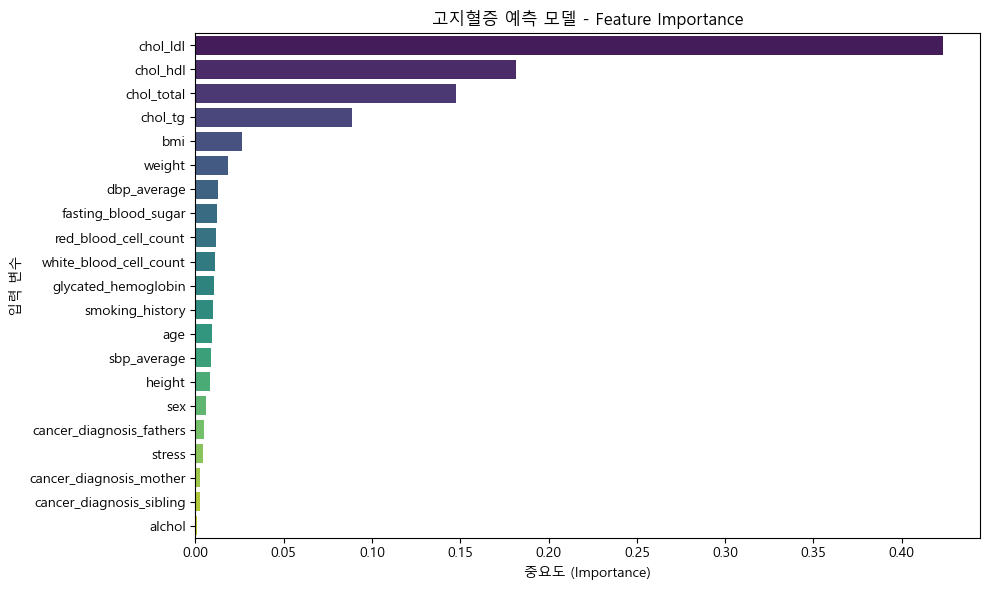

C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


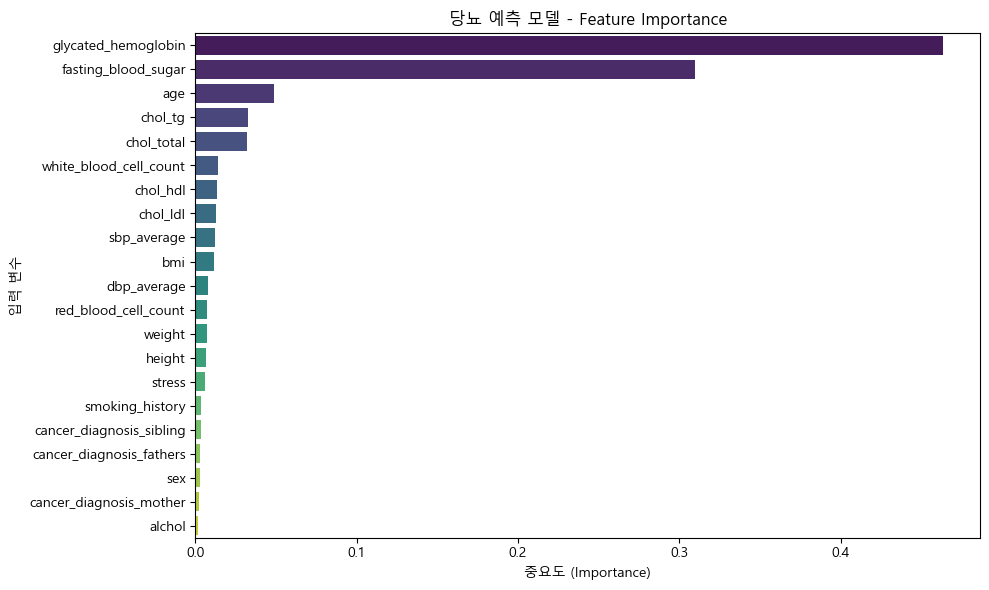

C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


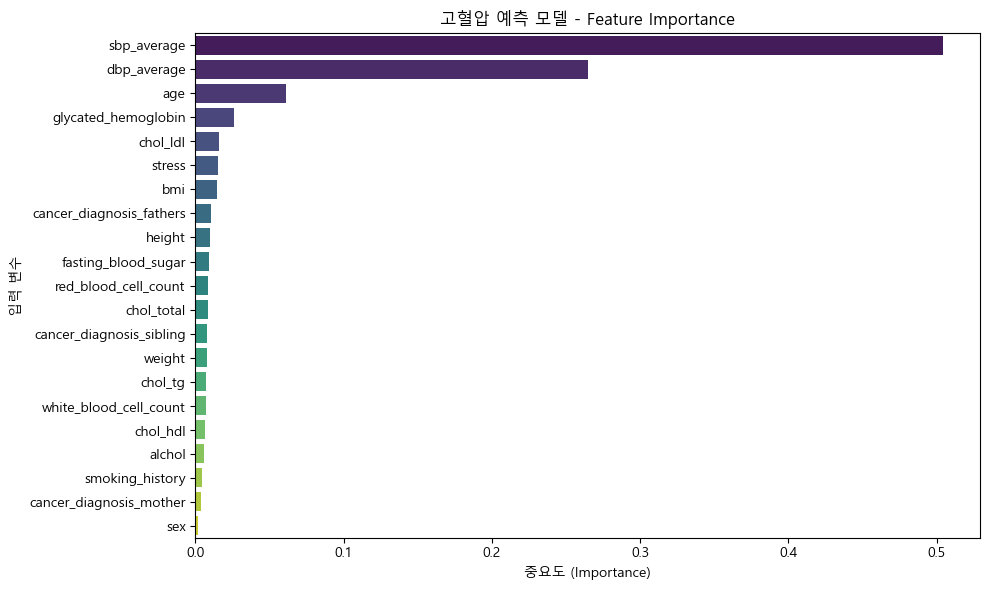

In [4]:
# üìå Í∞Å ÏßàÎ≥ëÏóê ÎåÄÌïú Feature Importance ÏãúÍ∞ÅÌôî
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")
    plt.title(f"{title} - Feature Importance")
    plt.xlabel("Ï§ëÏöîÎèÑ (Importance)")
    plt.ylabel("ÏûÖÎ†• Î≥ÄÏàò")
    plt.tight_layout()
    plt.show()

# üìå Í∞Å ÏßàÎ≥ë Î™®Îç∏Ïùò feature importance ÏãúÍ∞ÅÌôî
for disease, model in optimized_models.items():
    plot_feature_importance(model, columns_to_use, f"{disease} ÏòàÏ∏° Î™®Îç∏")


C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


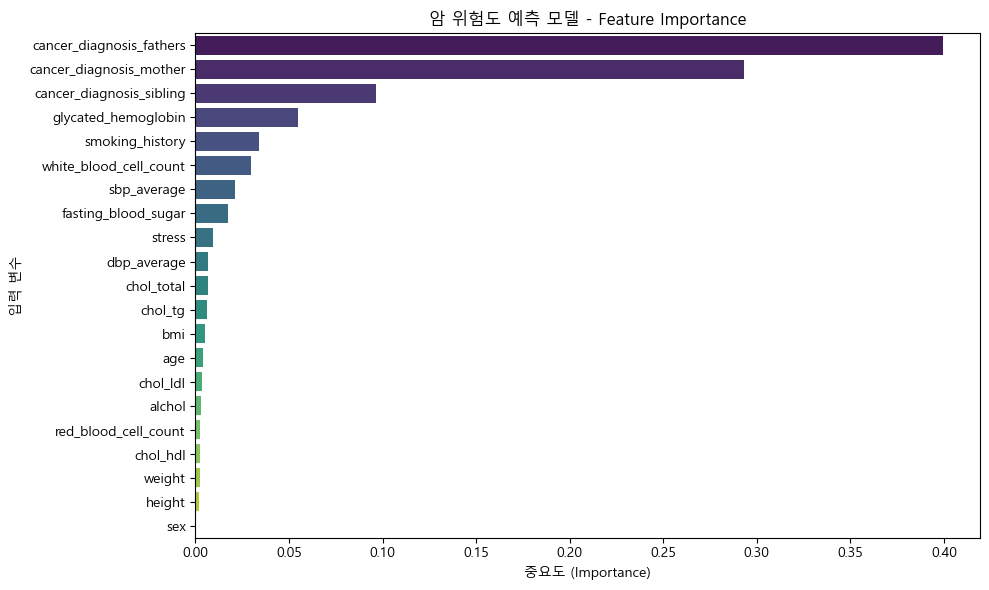

In [5]:
plot_feature_importance(cancer_model, columns_to_use, "Ïïî ÏúÑÌóòÎèÑ ÏòàÏ∏° Î™®Îç∏")


C:\Users\arsey\AppData\Local\Temp\ipykernel_18188\2154419459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


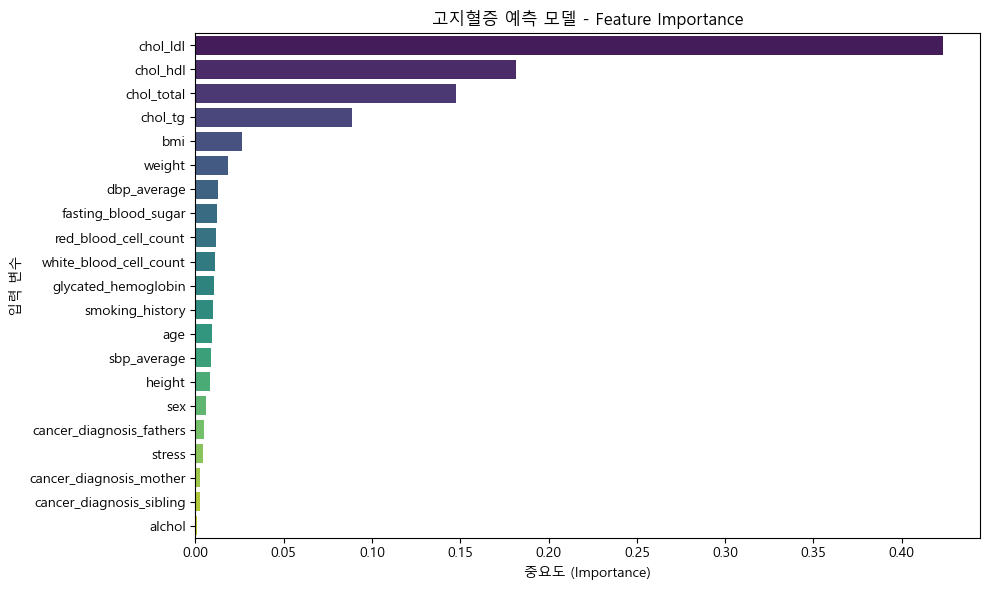

In [7]:
# Í≥†ÏßÄÌòàÏ¶ù ÏòàÏ∏° Î™®Îç∏ Feature Importance Î≥¥Í∏∞
plot_feature_importance(optimized_models["Í≥†ÏßÄÌòàÏ¶ù"], columns_to_use, "Í≥†ÏßÄÌòàÏ¶ù ÏòàÏ∏° Î™®Îç∏")


In [5]:
import mariadb
import pandas as pd

# DB Ïó∞Í≤∞ Ï†ïÎ≥¥
DB_CONFIG = {
    "user": "root",
    "password": "1234",
    "host": "localhost",
    "database": "finfit"
}

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Îäî Ìï®Ïàò
def load_data_from_db():
    conn = mariadb.connect(**DB_CONFIG)
    query = "SELECT * FROM medical"
    df = pd.read_sql(query, conn)
    conn.close()
    return df.dropna()

# ‚úÖ health_data Î≥ÄÏàò ÏÉùÏÑ±
health_data = load_data_from_db()
print(f"‚úÖ DBÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å! Ï¥ù {len(health_data)}Í∞úÏùò Îç∞Ïù¥ÌÑ∞")

C:\Users\arsey\AppData\Local\Temp\ipykernel_53332\3909213573.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


‚úÖ DBÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å! Ï¥ù 4599Í∞úÏùò Îç∞Ïù¥ÌÑ∞


In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ÏßàÎ≥ë ÎùºÎ≤® Ï†ïÏùò
disease_labels = {
    'Í≥†ÏßÄÌòàÏ¶ù': 'dyslipidemia_status',
    'ÎãπÎá®': 'diabetes',
    'Í≥†ÌòàÏïï': 'high_blood_pressure'
}

# ÏÇ¨Ïö©Ìï† ÌîºÏ≤ò
columns_to_use = [
    'sex', 'age', 'height', 'weight', 'bmi', 'alchol', 'smoking_history',
    'chol_total', 'chol_hdl', 'chol_ldl', 'chol_tg',
    'fasting_blood_sugar', 'glycated_hemoglobin',
    'sbp_average', 'dbp_average', 'cancer_diagnosis_fathers',
    'cancer_diagnosis_mother', 'cancer_diagnosis_sibling',
    'white_blood_cell_count', 'red_blood_cell_count', 'stress'
]

# X, y Î∂ÑÎ¶¨
X = health_data[columns_to_use]
y_disease = health_data[list(disease_labels.values())]

# Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨ + Ïä§ÏºÄÏùºÎßÅ
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X_train, X_test, y_train_disease, y_test_disease = train_test_split(
    X_scaled, y_disease, test_size=0.2, random_state=42
)

# SMOTE Ï†ÅÏö©
smote = SMOTE(random_state=42)
X_train_smote_dict = {}
y_train_smote_dict = {}

for disease, label in disease_labels.items():
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train_disease[label])
    X_train_smote_dict[disease] = X_resampled
    y_train_smote_dict[disease] = y_resampled


c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] ÏßÄÏ†ïÎêú ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\venvs\finfit\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\arsey\AppData\Local\Programs\Python\Python312\Lib\subprocess.

c:\venvs\finfit\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1127, number of negative: 1127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2254, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\venvs\finfit\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2667964237.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_list, y=list(models.keys()), palette='Blues_r')
C:\Users\arsey\AppData\Local\Temp\ipykernel_29980\2667964237.py:75: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\venvs\finfit\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


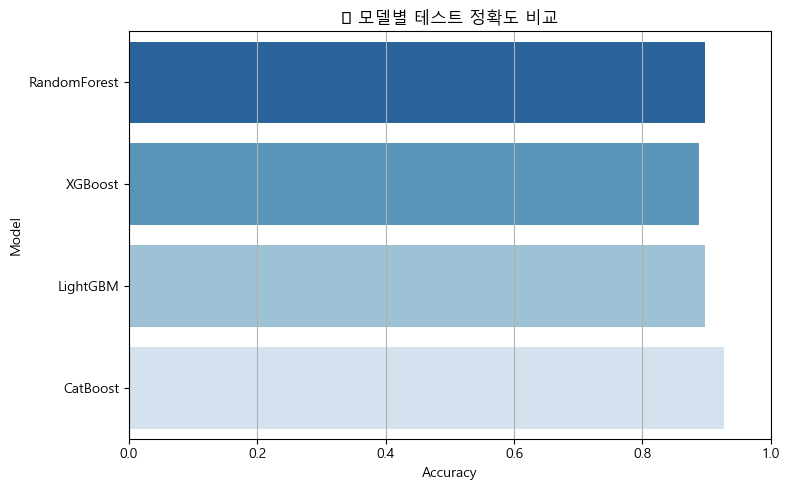

ModuleNotFoundError: No module named 'ace_tools'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

import seaborn as sns
import numpy as np

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (ÎåÄÏ≤¥Ïö©)
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10, 
                           n_classes=2, weights=[0.7, 0.3], random_state=42)

columns_to_use = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=columns_to_use)
df['target'] = y

# Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨ + Ï†ïÍ∑úÌôî
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(df.drop('target', axis=1))
X_scaled = scaler.fit_transform(X_imputed)
y = df['target'].values

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SMOTE Ï†ÅÏö©
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Î™®Îç∏ Ï†ïÏùò (Í∞ÑÎã®Ìïú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î°ú Îπ†Î•¥Í≤å ÎèåÎ¶¨Í∏∞)
models = {
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=50, depth=10, learning_rate=0.1, verbose=0, random_state=42)
}

# Í≤∞Í≥º Ï†ÄÏû•Ïö©
accuracy_list = []
feature_df_list = []

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracy_list.append(acc)

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_df = pd.DataFrame({
            'Feature': columns_to_use,
            'Importance': importance,
            'Model': name
        }).sort_values(by='Importance', ascending=False).head(5)
        feature_df_list.append(feature_df)

# Ï†ïÌôïÎèÑ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=accuracy_list, y=list(models.keys()), palette='Blues_r')
plt.title("üß† Î™®Îç∏Î≥Ñ ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ ÎπÑÍµê")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Feature Importance ÏãúÍ∞ÅÌôî
import ace_tools as tools; tools.display_dataframe_to_user(name="Î™®Îç∏Î≥Ñ ÏÉÅÏúÑ Ï§ëÏöî ÌîºÏ≤ò", dataframe=pd.concat(feature_df_list))


In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10,
                           n_classes=2, weights=[0.7, 0.3], random_state=42)
columns_to_use = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=columns_to_use)

# Ï†ÑÏ≤òÎ¶¨
imputer = SimpleImputer()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(imputer.fit_transform(df))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SMOTE Ï†ÅÏö©
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

models = {
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=10, learning_rate=0.1),
    "CatBoost": CatBoostClassifier(iterations=50, depth=10, learning_rate=0.1, verbose=0)
}

accuracy_list = []
feature_df_list = []

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    pred = model.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, pred))
    
    if hasattr(model, 'feature_importances_'):
        feature_df = pd.DataFrame({
            'Model': name,
            'Feature': columns_to_use,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).head(5)
        feature_df_list.append(feature_df)


c:\venvs\finfit\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1127, number of negative: 1127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2254, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\venvs\finfit\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


C:\Users\arsey\AppData\Local\Temp\ipykernel_53332\2119757337.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_list, y=list(models.keys()), palette='coolwarm')


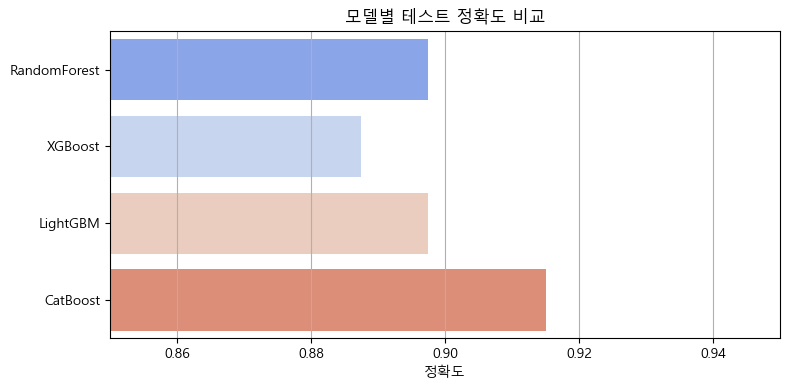

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x=accuracy_list, y=list(models.keys()), palette='coolwarm')
plt.title("Î™®Îç∏Î≥Ñ ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ ÎπÑÍµê")
plt.xlabel("Ï†ïÌôïÎèÑ")
plt.xlim(0.85, 0.95)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [16]:
comparison_table = pd.DataFrame({
    "Î™®Îç∏Î™Ö": ["RandomForest", "XGBoost", "LightGBM", "CatBoost"],
    "Ï†ïÌôïÎèÑ(Accuracy)": accuracy_list,
    "Ìï¥ÏÑù Ïö©Ïù¥ÏÑ±": ["ÎÜíÏùå", "Ï§ëÍ∞Ñ", "Ï§ëÍ∞Ñ", "ÎÇÆÏùå"],
    "ÌïôÏäµ ÏÜçÎèÑ": ["Îπ†Î¶Ñ", "Ï§ëÍ∞Ñ", "Îπ†Î¶Ñ", "ÎäêÎ¶º"],
    "ÏÜåÏàò ÌÅ¥ÎûòÏä§ ÎåÄÏùëÎ†•": ["ÎÇÆÏùå", "Ï§ëÍ∞Ñ", "Î≥¥ÌÜµ", "Ïö∞Ïàò"],
    "Ïû•Ï†ê": [
        "Ìï¥ÏÑù Ïâ¨ÏõÄ, ÌäúÎãù ÏóÜÏù¥ÎèÑ ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä•",
        "ÏÑ±Îä• Ïö∞Ïàò, Î≥µÏû°Ìïú Ìå®ÌÑ¥ ÌïôÏäµ Í∞ÄÎä•",
        "Îπ†Î•∏ ÌïôÏäµ ÏÜçÎèÑ, Ìö®Ïú®Ï†Å ÏûêÏõê ÏÇ¨Ïö©",
        "ÏÜåÏàò ÌÅ¥ÎûòÏä§Ïóê Í∞ïÌï®, ÎÜíÏùÄ ÏòàÏ∏°Î†•"
    ],
    "Îã®Ï†ê": [
        "Î≥µÏû°Ìïú Ìå®ÌÑ¥ÏóêÏÑú ÏÑ±Îä• ÌïúÍ≥Ñ",
        "ÌäúÎãù ÌïÑÏöî, ÌïôÏäµ ÏÜçÎèÑ ÎäêÎ¶¥ Ïàò ÏûàÏùå",
        "Îã§ÏÜå ÎØºÍ∞êÌï®, Í≥ºÏ†ÅÌï© Í∞ÄÎä•ÏÑ±",
        "ÌïôÏäµ ÏãúÍ∞Ñ Í∏∏Í≥† Ìï¥ÏÑù Ïñ¥Î†§ÏõÄ"
    ]
})
comparison_table


Î™®Îç∏Î™Ö  Ï†ïÌôïÎèÑ(Accuracy) Ìï¥ÏÑù Ïö©Ïù¥ÏÑ± ÌïôÏäµ ÏÜçÎèÑ ÏÜåÏàò ÌÅ¥ÎûòÏä§ ÎåÄÏùëÎ†•                     Ïû•Ï†ê  \
0  RandomForest         0.8975     ÎÜíÏùå    Îπ†Î¶Ñ         ÎÇÆÏùå  Ìï¥ÏÑù Ïâ¨ÏõÄ, ÌäúÎãù ÏóÜÏù¥ÎèÑ ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä•   
1       XGBoost         0.8875     Ï§ëÍ∞Ñ    Ï§ëÍ∞Ñ         Ï§ëÍ∞Ñ    ÏÑ±Îä• Ïö∞Ïàò, Î≥µÏû°Ìïú Ìå®ÌÑ¥ ÌïôÏäµ Í∞ÄÎä•   
2      LightGBM         0.8975     Ï§ëÍ∞Ñ    Îπ†Î¶Ñ         Î≥¥ÌÜµ    Îπ†Î•∏ ÌïôÏäµ ÏÜçÎèÑ, Ìö®Ïú®Ï†Å ÏûêÏõê ÏÇ¨Ïö©   
3      CatBoost         0.9150     ÎÇÆÏùå    ÎäêÎ¶º         Ïö∞Ïàò     ÏÜåÏàò ÌÅ¥ÎûòÏä§Ïóê Í∞ïÌï®, ÎÜíÏùÄ ÏòàÏ∏°Î†•   

                     Îã®Ï†ê  
0        Î≥µÏû°Ìïú Ìå®ÌÑ¥ÏóêÏÑú ÏÑ±Îä• ÌïúÍ≥Ñ  
1  ÌäúÎãù ÌïÑÏöî, ÌïôÏäµ ÏÜçÎèÑ ÎäêÎ¶¥ Ïàò ÏûàÏùå  
2       Îã§ÏÜå ÎØºÍ∞êÌï®, Í≥ºÏ†ÅÌï© Í∞ÄÎä•ÏÑ±  
3       ÌïôÏäµ ÏãúÍ∞Ñ Í∏∏Í≥† Ìï¥ÏÑù Ïñ¥Î†§ÏõÄ